# <font color='red'>**KANDINSKY**</font>: Clustering and Quantization   
  
## **K-Means (and friends)**  

*Shaurya Agarwal*

![K-Means and Friends](./images/07-kmeans-and-friends-abstract-cluster.png)

### <font color='green'>__Support for Google Colab__  </font>  
    
open this notebook in Colab using the following button:  
  
<a href="https://colab.research.google.com/github/shauryashaurya/kandinsky/blob/master/01-K-Means-and-friends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>  
  
<font color='green'>uncomment and execute the cell below to setup and run this notebook on Google Colab.</font>

In [1]:
# # SETUP FOR COLAB: select all the lines below and uncomment (CTRL+/ on windows)

# # Image conversion methods use OpenCV 
# # If the folders have already not been created, please do so
# # ideally you should have data in the ./data folder already (run the previous notebook)

# ! mkdir ./data
# ! mkdir ./data/cgi
# ! mkdir ./data/edtf
# ! pip install --upgrade --no-cache-dir jax cv2 numpy pandas skimage scikit-learn

## Setup, imports etc.

In [46]:
import concurrent.futures
import csv
import os
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from skimage import color
# 
import jax.numpy as jnp
from jax import random, jit


To render Matplotlib plots directly in a JupyterLab notebook, you can use the ```%matplotlib inline``` magic command. This command configures Matplotlib to render its plots inline within the Jupyter notebook cells, immediately below the code cells that produce them.  
For interactive plots within JupyterLab (e.g., for zooming and rotating 3D plots), you can use the ```%matplotlib widget``` magic instead.  
```%matplotlib widget``` requires ```ipympl``` package, ```pip install --upgrade --no-cache-dir ipympl``` if it's missing.  

In [12]:
%matplotlib widget

# Load image data and visualize 

In [13]:
# Load color space data from a CSV file
def load_data_from_csv(file_path):
    df = pd.read_csv(file_path)
    return df.to_numpy()

In [104]:
# Convert data from specified color space to RGB for visualization.
def convert_to_rgb(data, color_space):
    if color_space == "XYZ":
        return (
            (color.xyz2rgb(data.reshape(1, -1, 3)) * 255)
            .reshape(-1, 3)
            .astype(np.uint16)
        )
    elif color_space == "Lab":
        return (
            (color.lab2rgb(data.reshape(1, -1, 3)) * 255)
            .reshape(-1, 3)
            .astype(np.uint16)
        )
    elif color_space == "HSV":
        return (
            cv2.cvtColor(
                data.reshape(1, -1, 3).astype(np.float32), cv2.COLOR_HSV2RGB
            ).reshape(-1, 3)
            * 255
        )
    elif space == "RGB":
        return data  # Assuming RGB or already in RGB
    elif space == "HSL":
        raise ValueError("HSL not supported yet...")
    else:
        raise ValueError("Unsupported color space")	
	
# elif color_space == "HSL":
#     return (
#         cv2.cvtColor(
#             data.reshape(1, -1, 3).astype(np.float32), cv2.COLOR_HLS2RGB
#         ).reshape(-1, 3)
#         * 255
#     )

In [15]:
# Normalize color values to [0, 1] for plotting, depending on the color space.
# Normalizing data is crucial for modeling the clusters as well 
# - it minimizes the impact of dimensions of varied scale
# for e.g. if one dimension goes from 0 to 255 (let's say lots of R)
# but little to no blue, goes from 0 to 10
# then the distances will not mean much in the blue dimension
# unless we normalize (and linearize)

In [16]:
def normalize_colors_for_plotting(data, color_space="RGB"):
    if color_space in ["RGB", "HSV", "HSL"]:  # These are typically already in [0, 1]
        return data
    elif color_space == "XYZ":
        # Normalize XYZ based on typical ranges (may need adjustment based on actual data range)
        data /= np.max(data, axis=0)
    elif color_space == "Lab":
        # Normalize L in [0, 100], a and b in approximately [-110, 110]
        data = (data + [0, 110, 110]) / [100, 220, 220]
    return data

In [20]:
# Plot the loaded image and its 3D point cloud in the specified color space
# - color_space: The color space for the 3D point cloud ('RGB', 'XYZ', 'Lab', 'HSV', 'HSL').
# 
def plot_image_and_color_space(image_path, color_space="RGB"):
    # Load and normalize the image
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB) / 255.0

    # Convert the image to the specified color space
    if color_space == "RGB":
        data = image_rgb
        axes_titles = ["R", "G", "B"]
    elif color_space == "XYZ":
        data = color.rgb2xyz(image_rgb)
        axes_titles = ["X", "Y", "Z"]
    elif color_space == "Lab":
        data = color.rgb2lab(image_rgb)
        axes_titles = ["L", "a", "b"]
    elif color_space == "HSV":
        data = color.rgb2hsv(image_rgb)
        axes_titles = ["H", "S", "V"]
    # HSL not supported yet...
    elif color_space == "HSL":
        raise ValueError("HSL not supported yet...")
    else:
        raise ValueError("Unsupported color space")

    # Normalize color values for plotting
    data_for_plotting = normalize_colors_for_plotting(data.reshape(-1, 3), color_space)

    # Plot the image
    plt.figure(figsize=(9, 10))
	
    # Plot the 3D point cloud
    # just rendering the 3d
    ax = plt.subplot(1, 1, 1, projection="3d")
    ax.scatter(
        data_for_plotting[:, 0],
        data_for_plotting[:, 1],
        data_for_plotting[:, 2],
        c=data_for_plotting,
        marker="o",
        s=0.001,
    )
    ax.set_title(f"{color_space} Color Space")
    ax.set_xlabel(axes_titles[0])
    ax.set_ylabel(axes_titles[1])
    ax.set_zlabel(axes_titles[2])

    plt.show()
    # matplotlib.pyplot.close()

In [23]:
# Plot the 3D point cloud for pixel data in the specified color space, colored with original RGB values

def plot_color_space_with_rgb_colors(base_path, color_space="RGB"):	
    # Load Image (.png)
    image_bgr = cv2.imread(base_path+'.png')
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB) / 255.0

    # Load the color space data from CSV
    color_space_data = pd.read_csv(f"{base_path}_{color_space}.csv").to_numpy()

    # Load the corresponding RGB values from CSV
    rgb_data = pd.read_csv(f"{base_path}_RGB.csv").to_numpy()

    # Normalize RGB values to [0, 1] for matplotlib plotting
    rgb_colors = rgb_data / 255.0

    # TODO - Write better code - this is repetitive!
	# supply axis labels
    if color_space == "RGB":
        axes_titles = ["R", "G", "B"]
    elif color_space == "XYZ":
        axes_titles = ["X", "Y", "Z"]
    elif color_space == "Lab":
        axes_titles = ["L", "a", "b"]
    elif color_space == "HSV":
        axes_titles = ["H", "S", "V"]
    # HSL not supported yet...
    elif color_space == "HSL":
        raise ValueError("HSL not supported yet...")
    else:
        raise ValueError("Unsupported color space")

    fig = plt.figure(figsize=(10, 5))
    # plt.subplot needs (rows, columns, index of current plot)
    plt.subplot(1, 2, 2)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Original Image')
    
    # Plot the 3D point cloud
    ax = plt.subplot(1, 2, 1, projection="3d")

    ax.scatter(
        color_space_data[:, 0],
        color_space_data[:, 1],
        color_space_data[:, 2],
        c=rgb_colors,
        marker="o",
        s=0.005,
    )

    ax.set_title(f"{color_space} Color Space Point Cloud Colored by RGB")
    ax.set_xlabel(axes_titles[0])
    ax.set_ylabel(axes_titles[1])
    ax.set_zlabel(axes_titles[2])

    plt.show()

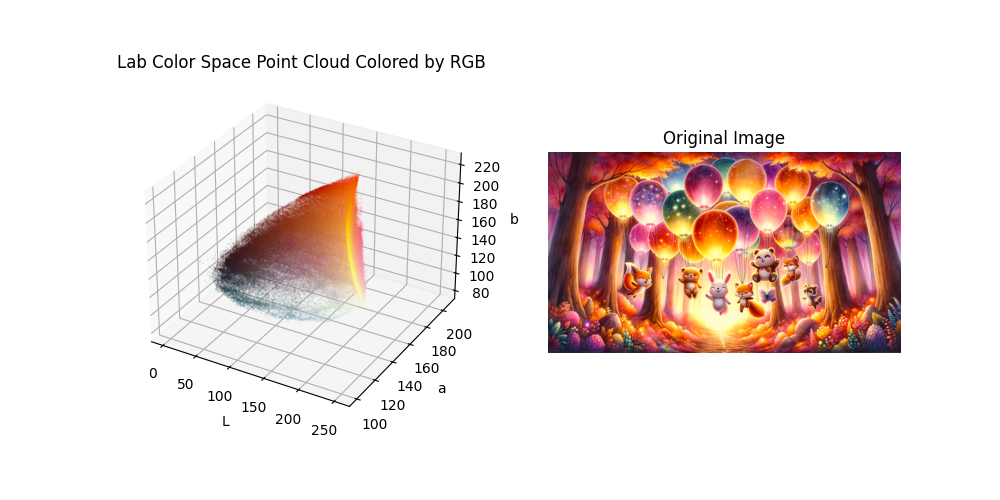

In [22]:
base_path = "./data/cgi/01x25"  # Without the color space suffix and .csv
color_space = "Lab"  # Example color space
plot_color_space_with_rgb_colors(base_path, color_space)

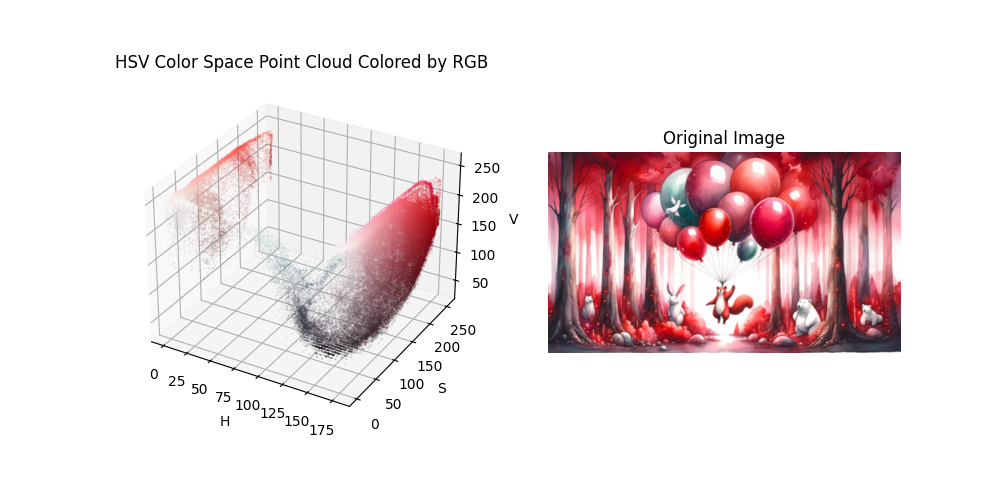

In [24]:
# plot_color_space_with_rgb_colors('./data/cgi/01x25', 'Lab')
plot_color_space_with_rgb_colors('./data/cgi/02x25', 'HSV')
# plot_color_space_with_rgb_colors('./data/cgi/03x25', 'XYZ')
# plot_color_space_with_rgb_colors('./data/cgi/04x25', 'Lab')
# plot_color_space_with_rgb_colors('./data/cgi/05x25', 'HSV')
# plot_color_space_with_rgb_colors('./data/cgi/06x25', 'XYZ')

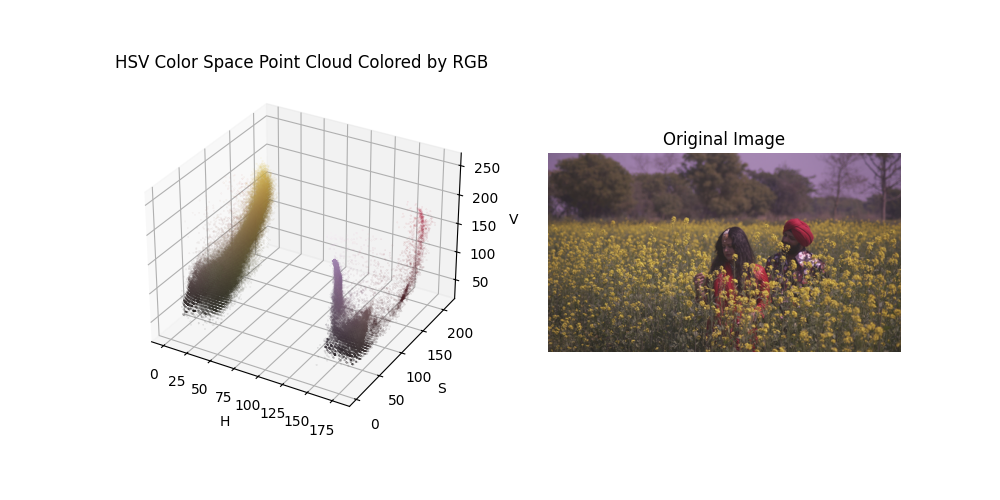

In [25]:
plot_color_space_with_rgb_colors('./data/edtf/001', 'HSV')
# plot_color_space_with_rgb_colors('./data/edtf/002', 'HSV')
# plot_color_space_with_rgb_colors('./data/edtf/003', 'XYZ')
# plot_color_space_with_rgb_colors('./data/edtf/004', 'Lab')
# plot_color_space_with_rgb_colors('./data/edtf/005', 'HSV')
# plot_color_space_with_rgb_colors('./data/edtf/006', 'XYZ')
# plot_color_space_with_rgb_colors('./data/edtf/007', 'Lab')
# plot_color_space_with_rgb_colors('./data/edtf/008', 'HSV')
# plot_color_space_with_rgb_colors('./data/edtf/009', 'XYZ')
# plot_color_space_with_rgb_colors('./data/edtf/010', 'Lab')
# plot_color_space_with_rgb_colors('./data/edtf/011', 'Lab')
# plot_color_space_with_rgb_colors('./data/edtf/012', 'Lab')

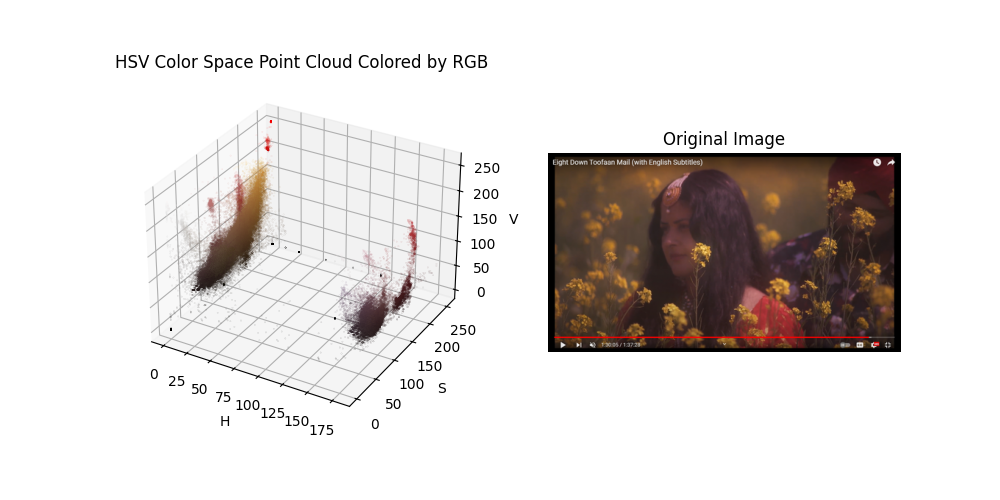

In [26]:
# plot_color_space_with_rgb_colors('./data/edtf/001', 'HSV')
# plot_color_space_with_rgb_colors('./data/edtf/002', 'HSV')
# plot_color_space_with_rgb_colors('./data/edtf/003', 'XYZ')
# plot_color_space_with_rgb_colors('./data/edtf/004', 'Lab')
# plot_color_space_with_rgb_colors('./data/edtf/005', 'HSV')
# plot_color_space_with_rgb_colors('./data/edtf/006', 'XYZ')
# plot_color_space_with_rgb_colors('./data/edtf/007', 'Lab')
# plot_color_space_with_rgb_colors('./data/edtf/008', 'HSV')
# plot_color_space_with_rgb_colors('./data/edtf/009', 'XYZ')
# plot_color_space_with_rgb_colors('./data/edtf/010', 'Lab')
plot_color_space_with_rgb_colors('./data/edtf/011', 'HSV')
# plot_color_space_with_rgb_colors('./data/edtf/012', 'RGB')

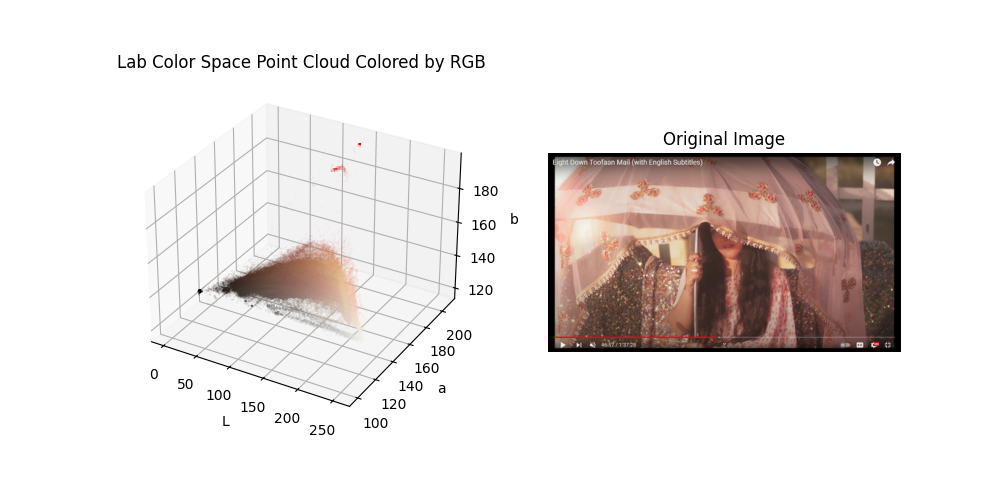

In [27]:
# plot_color_space_with_rgb_colors('./data/edtf/001', 'HSV')
# plot_color_space_with_rgb_colors('./data/edtf/002', 'HSV')
# plot_color_space_with_rgb_colors('./data/edtf/003', 'XYZ')
# plot_color_space_with_rgb_colors('./data/edtf/004', 'Lab')
# plot_color_space_with_rgb_colors('./data/edtf/005', 'HSV')
# plot_color_space_with_rgb_colors('./data/edtf/006', 'XYZ')
# plot_color_space_with_rgb_colors('./data/edtf/007', 'Lab')
# plot_color_space_with_rgb_colors('./data/edtf/008', 'HSV')
# plot_color_space_with_rgb_colors('./data/edtf/009', 'XYZ')
# plot_color_space_with_rgb_colors('./data/edtf/010', 'Lab')
# plot_color_space_with_rgb_colors('./data/edtf/011', 'Lab')
plot_color_space_with_rgb_colors('./data/edtf/012', 'Lab')

# K-Means 

## Distance 
How do you calculate if a point is "near" or "far" from another?  

In [28]:
# Calculates the Cartesian (Euclidean) distance between two points.
def cartesian_distance(point1, point2):
    diff = point1 - point2  
    squared_diff = diff ** 2
    return jnp.sqrt(jnp.sum(squared_diff))

In [29]:
# Calculates the Manhattan distance between two points.
def manhattan_distance(point1, point2):
    return jnp.sum(jnp.abs(point1 - point2)) 

In [30]:
# Compute the Euclidean distance between two sets of points.
# same as cartesian distance
def euclidean_distance(x, y):
    # return jnp.sqrt(jnp.sum((x[:, None, :] - y[None, :, :]) ** 2, axis=-1))
	return cartesian_distance(x,y)

## Initialize, Assign, Update, Repeat
### ...and Limit

In [105]:
# num_iters defines the limit
def kmeans_jax(data, k, num_iters=10):
    rng = random.PRNGKey(0)
    n, d = data.shape
	# Initilize
    centroids = data[random.choice(rng, jnp.arange(n), shape=(k,), replace=False)]
	# 
	# Limit to num_iters cycles
    for i in range(num_iters):
        # Assign clusters
        distances = jnp.sqrt(jnp.sum((data[:, None, :] - centroids[None, :, :]) ** 2, axis=2))
        closest_centroids = jnp.argmin(distances, axis=1)
		
        # Update centroids
        centroids = jnp.array([data[closest_centroids == c].mean(axis=0) for c in range(k)])

    return centroids, closest_centroids

In [154]:
# Load image
image_path = './data/edtf/012.png'
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# or 
# Load the data from CSV files
data_csv_path = './data/edtf/012_Lab.csv'
pixels_raw = pd.read_csv(data_csv_path).to_numpy()

# Normalize and reshape the image data to fit K-Means input
# both methods below are equivalent
# pixels = image_rgb.reshape(-1, 3) / 255.0  # Normalize to [0, 1]
pixels = pixels_raw.reshape(-1, 3) / 255.0  # Normalize to [0, 1]

In [155]:
pixels.shape

(129600, 3)

In [156]:
# grab a random set of pixels, see what it looks like
pixels[5000:5010]

array([[0.56862745, 0.50980392, 0.52941176],
       [0.32156863, 0.5254902 , 0.56470588],
       [0.27058824, 0.52941176, 0.57254902],
       [0.45882353, 0.5254902 , 0.5372549 ],
       [0.65098039, 0.51764706, 0.51764706],
       [0.54509804, 0.5254902 , 0.53333333],
       [0.32941176, 0.54117647, 0.56470588],
       [0.27843137, 0.55294118, 0.57254902],
       [0.74509804, 0.50980392, 0.51764706],
       [0.61568627, 0.52156863, 0.52156863]])

In [157]:
data_jax = jnp.array(pixels)  # Convert NumPy array to JAX array

In [145]:
k = 3  # Number of clusters

In [146]:
centroids, labels = kmeans_jax(data_jax, k, num_iters=10)

In [147]:
def convert_to_rgb_pd(data, space):
	data = pd.DataFrame(data).to_numpy()
	# print('convert_to_rgb2: data:', data)
	# Convert the image to the specified color space
	if space == "RGB":
		data = data
		# data = data.astype(np.uint8)
		axes_titles = ["R", "G", "B"]
	elif space == "XYZ":
		data = color.xyz2rgb(data)
		axes_titles = ["X", "Y", "Z"]
	elif space == "Lab":
		# we'll talk about the illuminant in a later notebook
		# it's basically an indicator of the
		# kelvin temperature 
		# that represents 'White' in daylight
		data = color.lab2rgb(data,illuminant='D65')
		axes_titles = ["L", "a", "b"]
	elif space == "HSV":
		data = color.hsv2rgb(data)
		# data = cv2.cvtColor(data, cv2.COLOR_HSV2RGB)
		axes_titles = ["H", "S", "V"]
	# HSL not supported yet...
	elif space == "HSL":
		raise ValueError("HSL not supported yet...")
	else:
		raise ValueError("Unsupported color space")
	return (data.astype(np.uint16))

In [148]:
centroids_rgb = convert_to_rgb(centroids,'Lab')

In [149]:
print('centroids: ', centroids)
print('centroids_rgb: ', centroids_rgb)
print('labels: ', labels)

centroids:  [[1.402476   1.0959853  1.1136992 ]
 [0.8135376  1.112286   1.0951508 ]
 [0.26188347 1.0381975  1.0335655 ]]
centroids_rgb:  [[9 4 2]
 [7 1 0]
 [4 0 0]]
labels:  [2 2 2 ... 2 2 2]


In [150]:
# Map each pixel to its centroid color
# segmented_image = jnp.array([centroids[label] for label in labels])

In [151]:
segmented_image = centroids[labels].reshape(image_rgb.shape)
# segmented_image = centroids_rgb[labels].reshape(image_rgb.shape)

In [152]:
# Reshape back to the original image shape
segmented_image = segmented_image.reshape(image_rgb.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


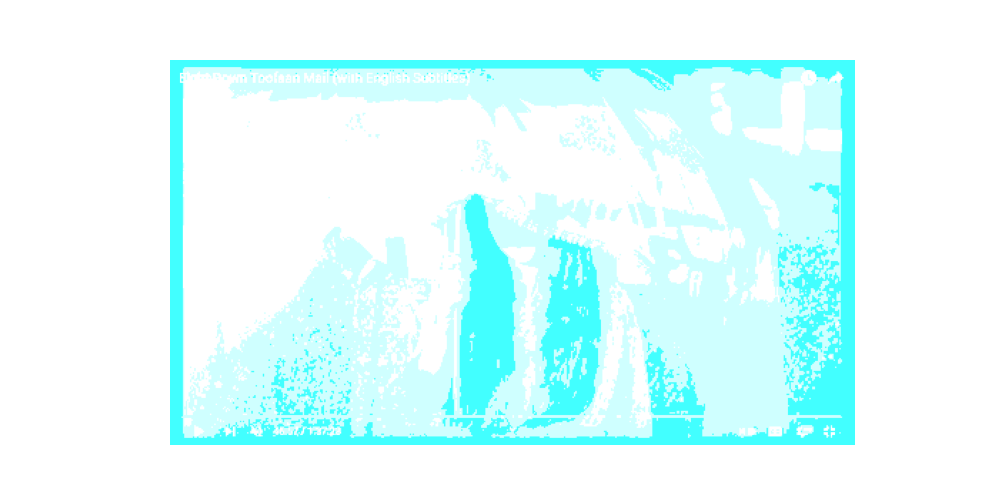

In [153]:
# Display the result
import matplotlib.pyplot as plt

fig2 = plt.figure(figsize=(10, 5))
plt.imshow(segmented_image)
plt.axis('off')  # Hide axes
plt.show()